# RL homework 1



**Due date: 19 February 2017, 11:55pm (just before mid-night!)**

## How to submit

When you have completed the exercises and everything has finsihed running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as studentnumber_DL_hw2.ipynb before the deadline above.



## Context

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

## Background reading

* Sutton and Barto (2018), Chapters 1 and 2

# The Assignment

### Objectives

You will use Python to implement several bandit algorithms.

You will then run these algorithms on a multi-armed Bernoulli bandit problem, to understand the issue of balancing exploration and exploitation.

# Setup

### Import Useful Libraries

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

### Set options

In [0]:
np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

### A generic multi-armed bandit class, with Bernoulli rewards

In [0]:
class BernoulliBandit(object):
  """A stationary multi-armed Bernoulli bandit."""
  
  def __init__(self, success_probabilities, success_reward=1., fail_reward=0.):
    """Constructor of a stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or tf.int32 that specifies which arm to pull.

    Returns:
      A sampled reward according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    return reward

### Helper functions

In [0]:
def smooth(array, smoothing_horizon=100., initial_value=0.):
  """smoothing function for plotting"""
  smoothed_array = []
  value = initial_value
  b = 1./smoothing_horizon
  m = 1.
  for x in array:
    m *= 1. - b
    lr = b/(1 - m)
    value += lr*(x - value)
    smoothed_array.append(value)
  return np.array(smoothed_array)

def one_hot(array, depth):
  """Multi-dimensional one-hot"""
  a = np.array(array)
  x = a.flatten()
  b = np.eye(depth)[x, :depth]
  return b.reshape(a.shape + (depth,))

def plot(algs, plot_data, optimal_value, repetitions=30):
  """Plot results of a bandit experiment."""
  algs_per_row = 3
  n_algs = len(algs)
  n_rows = (n_algs - 2)//algs_per_row + 1
  fig = plt.figure(figsize=(15, 5*n_rows))
  
  for i, p in enumerate(plot_data):
    for c in range(n_rows):
      ax = fig.add_subplot(n_rows, len(plot_data), i + 1 + c*len(plot_data))
      ax.grid(0)
      ax.set_axis_bgcolor('white')

      current_algs = [algs[0]] + algs[c*algs_per_row + 1:(c + 1)*algs_per_row + 1]
      for alg in current_algs:
        data = p.data[alg.name]
        m = smooth(np.mean(data, axis=0))
        s = np.std(smooth(data.T).T, axis=0)/np.sqrt(repetitions)
        if p.log_plot:
          line = plt.semilogy(m, alpha=0.6, label=alg.name)[0]
        else:
          line = plt.plot(m, alpha=0.6, label=alg.name)[0]
          plt.fill_between(range(number_of_steps), m + s, m - s,
                           color=line.get_color(), alpha=0.2)
      if not p.log_plot:
        plt.plot([0, number_of_steps], [optimal_value]*2, '--k', label='optimal')

      plt.ylim(p.ylim)
      plt.title(p.title)
      if i == len(plot_data) - 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def run_experiment(bandit, algs, repetitions):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  action_dict = {}

  for alg in algs:
    reward_dict[alg.name] = []
    action_dict[alg.name] = []
    
    for _ in range(repetitions):
      alg.reset()
      reward_dict[alg.name].append([])
      action_dict[alg.name].append([])
      action = None
      reward = None
      for i in range(number_of_steps):
        
        action = alg.step(action, reward)
          
        reward = bandit.step(action)
        reward_dict[alg.name][-1].append(reward)
        action_dict[alg.name][-1].append(action)
#         print(reward_dict)
#         print(action_dict)
        
  return reward_dict, action_dict

def train_agents(agents, number_of_arms, number_of_steps, repetitions=30,
                 success_reward=1., fail_reward=0.):

  success_probabilities = np.arange(0.25, 0.75 + 1e-6, 0.5/(number_of_arms - 1))
  bandit = BernoulliBandit(success_probabilities, success_reward, fail_reward)

  max_p = np.max(success_probabilities)
  min_p = np.min(success_probabilities)
  ylim_max = max_p*success_reward + (1 - max_p)*fail_reward
  ylim_min = min_p*success_reward + (1 - min_p)*fail_reward
  dif = ylim_max - ylim_min
  ylim = (ylim_min - 0.1*dif, ylim_max + 0.1*dif)

  max_prob = np.max(success_probabilities)
  optimal_value = max_prob*success_reward + (1 - max_prob)*fail_reward

  reward_dict, action_dict = run_experiment(bandit, agents, repetitions)
  
  smoothed_rewards = {}
  expected_rewards = {}
  regrets = {}
  for agent, rewards in reward_dict.items():
    smoothed_rewards[agent] = np.array(rewards)
  for agent, actions in action_dict.items():
    p_success = one_hot(actions, number_of_arms).dot(success_probabilities)
    expected_rewards[agent] = p_success*success_reward + (1 - p_success)*fail_reward
    regrets[agent] = optimal_value - expected_rewards[agent]

  PlotData = namedtuple('PlotData', ['title', 'data', 'log_plot', 'ylim'])
  plot_data = [
      PlotData(title='Smoohted rewards', data=smoothed_rewards,
               log_plot=False, ylim=ylim),
      PlotData(title='Expected rewards', data=expected_rewards,
               log_plot=False, ylim=ylim),
      PlotData(title='Current Regret', data=regrets,
               log_plot=True, ylim=(1e-2, 1)),
      PlotData(title='Total Regret',
               data=dict([(k, np.cumsum(v, axis=1)) for k, v in regrets.items()]),
               log_plot=False, ylim=(1e-0, 5e2)),
  ]

  plot(agents, plot_data, optimal_value)

### Random agent

In [0]:
class Random(object):
  """A random agent.
  
  This agent returns an action between 0 and 'number_of_arms', 
  uniformly at random. The 'previous_action' argument of 'step'
  is ignored.
  """

  def __init__(self, number_of_arms):
    self._number_of_arms = number_of_arms
    self.name = 'random'
    self.reset()

  def step(self, previous_action, reward):
    return np.random.randint(self._number_of_arms)

  def reset(self):
    pass

# A1: Implement agents

Each agent, should implement the following methods:

### `step(self, previous_action, reward)`:
should update the statistics by updating the value for the previous_action towards the observed reward.

(Note: make sure this can handle the case that previous_action=None, in which case no statistics should be updated.)

(Hint: you can split this into two steps: 1. update values, 2. get new action.  Make sure you update the values before selecting a new action.)

### `reset(self)`:
resets statistics (should be equivalent to constructing a new agent from scratch).  Make sure that the initial values (after a reset) are all zero.

### `__init__(self)`:
The `__init__` can be *the same* as for the random agent above (with the exception of $\epsilon$-greedy---see below), except for the name, which should be unique (e.g., 'greedy', 'ucb', etc.)

All agents should be in pure Python - so you cannot use TensorFlow to, e.g., compute gradients.  Using `numpy` is fine.



## Agent 1: greedy
**[10 pts]** You should **implement the greedy** agent, that

1.   Estimates the average reward for each action that was selected so far, and
2.   Always selects the highest-valued action.


In [0]:
class Greedy(object):

  def __init__(self, number_of_arms):
    self._number_of_arms = number_of_arms
    self.name = 'greedy'
    self.reward_counts = [0. for l in range(number_of_arms)]
    self.action_counts = [0 for l in range(number_of_arms)]
    self.reset()
  
  def step(self, previous_action, reward):
    # No previous_action then randomly select one action 
    
    if previous_action == None:
      return np.random.randint(self._number_of_arms)   
    else:
      self.action_counts[previous_action] += 1
      
      n = self.action_counts[previous_action]
      self.reward_counts[previous_action] = (((n-1) / float(n))* self.reward_counts[previous_action] + 
          (1/float(n)) * reward)
      
#       if self.reward_counts == [0. for l in range(self._number_of_arms)]: 
#         return np.random.randint(self._number_of_arms)
#       else:
      return np.argmax(self.reward_counts)
      
    
  def reset(self):
    self.reward_counts = [0. for l in range(self._number_of_arms)]
    self.action_counts = [0 for l in range(self._number_of_arms)]


## Agent 2: $\epsilon$-greedy
**[15 pts]** You should **implement an $\epsilon$-greedy** agent, that selects the highest-valued action with probability $1 - \epsilon$, and otherwise selects an action at random.

The exploration parameter $\epsilon$ should be given in the `__init__`, as indicated in the code below.


In [0]:
class EpsilonGreedy(object):

  def __init__(self, number_of_arms, epsilon=0.1):
    self._number_of_arms = number_of_arms
    self._epsilon = epsilon
    self.name = 'epsilon-greedy epsilon:{}'.format(epsilon)
    self.reward_counts = [0. for l in range(number_of_arms)]
    self.action_counts = [0 for l in range(number_of_arms)]
    self.reset()
  
  def step(self, previous_action, reward):
    # No previous_action then randomly select one action 
    
    if previous_action == None:
      return np.random.randint(self._number_of_arms)   
    else:
      self.action_counts[previous_action] += 1
      
      n = self.action_counts[previous_action]
      self.reward_counts[previous_action] = (((n-1) / float(n))* self.reward_counts[previous_action] + 
          (1/float(n)) * reward)
      
#       if self.reward_counts == [0. for l in range(self._number_of_arms)]: 
#         return np.random.randint(self._number_of_arms)
      
#       else:
      if np.random.random() > self._epsilon:
        return np.argmax(self.reward_counts)
      else:
        return np.random.randint(self._number_of_arms)

  
  def reset(self):
    self.reward_counts = [0. for l in range(self._number_of_arms)]
    self.action_counts = [0 for l in range(self._number_of_arms)]


## Agent 3: UCB
**[15 pt]** You should **implement** an agent that **explores with UCB**. 


In [0]:
class UCB(object):

  def __init__(self, number_of_arms):
    self._number_of_arms = number_of_arms
    self.name = 'ucb'
    self.reward_counts = [0. for l in range(number_of_arms)]
    self.action_counts = [0 for l in range(number_of_arms)]
    self.reset()
  
  def step(self, previous_action, reward):
    
    if previous_action == None:
      return np.random.randint(self._number_of_arms)   
    
    else:
      self.action_counts[previous_action] += 1
      
      n = self.action_counts[previous_action]
      self.reward_counts[previous_action] = (((n-1) / float(n))* self.reward_counts[previous_action] + 
          (1/float(n)) * reward)
      
#       if self.reward_counts == [0. for l in range(self._number_of_arms)]: 
#         return np.random.randint(self._number_of_arms)
      
#       else:
      t = np.sum(self.action_counts)
      #pick hyper-parameter c = 1， add a very small number to avoid zero dividend   
      uncertainty = np.sqrt(np.log(t)/(np.asarray(self.action_counts) + 0.00001))
      return np.argmax(self.reward_counts + uncertainty)
        
  def reset(self):
    self.reward_counts = [0. for l in range(self._number_of_arms)]
    self.action_counts = [0 for l in range(self._number_of_arms)]



## Agent 4: REINFORCE agents
You should implement agents that implement REINFORCE policy-gradient methods

The policy should be a softmax on action preferences:
$$\pi(a) = \frac{\exp(p(a))}{\sum_b \exp(p(b))}\,.$$

The action preferences are stored separately, so that for each action $a$ the preference $p(a)$ is a single value that you directly update.



## Assignment 4a:
In the next text field, write down the update function to the preferences for all actions $\{a_1, \ldots, a_n\}$ if you selected a specific action $A_t = a_i$ and received a reward of $R_t$.

In other words, complete:
\begin{align*}
p_{t+1}(a)
& = \ldots
&& \text{for $a = A_t$} \\
p_{t+1}(b)
& = \ldots
&& \text{for all $b \ne A_t$}
\end{align*}

**[10 pts]** **Instructions**: please provide answer in markdown below.

Here we apply gradient bandits:
$$p_{t+1}(a) = p_t(a) + \alpha \frac{\partial \mathop{\mathbb{E}[R_t]} }{\partial p_t(a)}$$
where the measure of performance is the expected reward $\mathop{\mathbb{E}(R_t)}$.

We apply reinforce trick(log-like):
$$ {\bigtriangledown}_{\theta} \mathop{\mathbb{E}[R_t|\theta]} = \mathop{\mathbb{E}[R_t{\bigtriangledown}_{\theta}log \pi_{\theta}(A_t)]} $$
so
$$ \theta = \theta +\alpha R_t {\bigtriangledown}_{\theta}log \pi_{\theta}(A_t) $$
$$p_{t+1}(a) = p_t(a) + \alpha R_t \frac{\partial log \pi_t(A_t)}{\partial p_t(a)} =  p_t(a) + \alpha R_t(\mathop{\mathbb{I}}(a = A_t)-\pi_t(a)) $$
If we set a baseline:
Since $\sum_a \pi_{\theta}(a)=1$,Therefore, for any baseline$b$, 
$$ \sum_a b {\bigtriangledown}_{\theta}\pi_{\theta}(a) = {\bigtriangledown}_{\theta}\sum_a \pi_{\theta}(a) = {\bigtriangledown}_{\theta} b =0 $$
as long as b does not depend on $\theta$ or $a$.

Therefore, 
$$\theta = \theta +\alpha( R_t -b ) {\bigtriangledown}_{\theta}log \pi_{\theta}(A_t)$$

Therefore, 
\begin{align*}
p_{t+1}(a)
& = p_{t}(a)+ \alpha (R_t -\bar{R_t})(1-\pi_t(a) )
&& \text{for $a = A_t$} \\
p_{t+1}(b)
& = p_{t}(b) - \alpha (R_t -\bar{R_t})\pi_t(b) 
&& \text{for all $b \ne A_t$}
\end{align*}

where $\alpha >0$ is a step-size parameter, and $\bar{R_t}$ is the average of all the reward up to time t.



## Assignment 4b:
**[15 + 5 pts]** You should **implement a vanilla REINFORCE agent with** and **without a baseline**.
Whether or not a baseline is used should be a boolean constructor argument.

In [0]:
class REINFORCE(object):
 
  def __init__(self, number_of_arms, step_size=0.1, baseline=False):
    self._number_of_arms = number_of_arms
    self._lr = step_size
    self.name = 'reinforce, baseline: {}'.format(baseline)
    self._baseline = baseline
    self.preference = [0. for l in range(number_of_arms)]
    self.reward_counts = [0. for l in range(number_of_arms)]
    self.action_counts = [0 for l in range(number_of_arms)]
    self.policy = [1./number_of_arms for l in range(number_of_arms)] 
    self.reset()
  
  def step(self, previous_action, reward):
    
    if previous_action == None:
      return np.random.randint(self._number_of_arms)
    
    else:
      self.action_counts[previous_action] += 1
      self.reward_counts[previous_action] += reward
      
      if self._baseline == True:
        b = np.sum(self.reward_counts)/np.sum(self.action_counts)
      else:        
        b = 0.  
      
#       if self.reward_counts == [0. for l in range(self._number_of_arms)]:
#         return np.random.randint(self._number_of_arms)
      
#       else:
      for i in range(self._number_of_arms):   
        self.preference[i] += self._lr * (reward - b) * (bool(previous_action == i) - self.policy[i])
          
      self.policy = np.exp(self.preference)/np.sum(np.exp(self.preference))

#         return np.argmax(self.policy)
      return np.random.choice(np.arange(len(self.policy)),p=self.policy)

      
  def reset(self):

    self.preference = [0. for l in range(self._number_of_arms)]
    self.reward_counts = [0. for l in range(self._number_of_arms)]
    self.action_counts = [0 for l in range(self._number_of_arms)]
    self.policy = [1./self._number_of_arms for l in range(self._number_of_arms)] 


# Assignment 5: Analyse Results

### Run the cell below to train the agents and generate the plots for the first experiment.

Trains the agents on a Bernoulli bandit problem with 5 arms,
with a reward on success of 1, and a reward on failure of 0.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


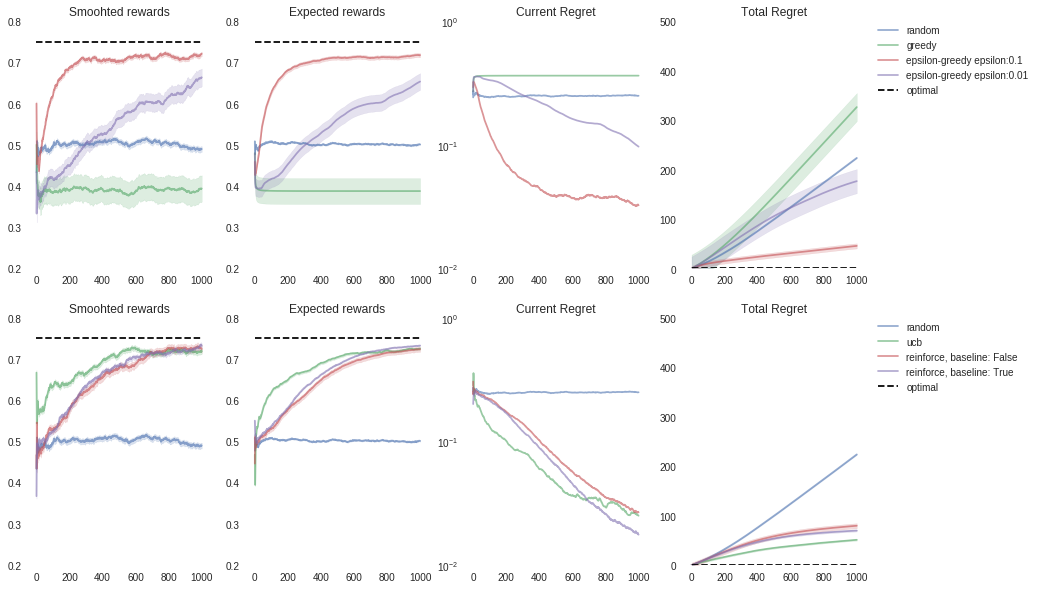

In [32]:
#@title Experiment 1: Bernoulli bandit

number_of_arms = 5
number_of_steps = 1000

agents = [
    Random(number_of_arms),
    Greedy(number_of_arms),
    EpsilonGreedy(number_of_arms, 0.1),
    EpsilonGreedy(number_of_arms, 0.01),
    UCB(number_of_arms),
    REINFORCE(number_of_arms),
    REINFORCE(number_of_arms, baseline=True),
]

train_agents(agents, number_of_arms, number_of_steps)

## Assignment 5 a.
(Answer inline in the markdown below each question.)

**[5pts]** Name the best and worst algorithms, and explain (with one or two sentences each) why these are best and worst.

*UCB is the best algorithm, with hyperpremeter $c=1$, we choose according to:$$a_t = argmax_{a} (Q_t(a) + c \sqrt{\frac{log (t)}{N_t(a)}})$$ We add uncertainty (increases get smaller over time, however, are unbounded) which ensures that we always keep exploring. All action will be selected eventually, while the actions with lower rewards or been selected frequently, will been selected with decreasing frequency over time. UCB forces non-greedy actions to be tried, and hence have the potential to reach the optimal.*

*Greedy is the worst, once the first rewards occurs, the algorithm will stay with the corresponding action, but this action may have lower probability to get a reward than selecting by random, while because the first reward, we won't have opportunity to try other actions.*

**[5pts]** Which algorithms are guaranteed to have linear total regret?

*Greedy and $\epsilon$-greedy algorithms have linear total regret. Greedy stay on a suboptiaml action forever, and $\epsilon$-greedy stay with probability $1-\epsilon$.*

**[5pts]** Which algorithms are guaranteed to have logarithmic total regret?

*UCB algorithm. We considerd the uncertainty in terms of natural logarithm of time $t$.*

**[5pts]** Which of the $\epsilon$-greedy algorithms performs best?  Which should perform best in the long run?

*$\epsilon = 0.1$ performed better. $\epsilon = 0.01$ method improved more slowly, however, should perform better in the long run. Since $\epsilon = 0.1$ method explored more, and thus is able to find optimal action more quickly, but never select an action with more than 96% of the time, $\epsilon = 0.01$ method is more slowly, while once the best action found, it can stay with that action with higher probability. *


### Run the cell below to train the agents and generate the plots for the second experiment.

Trains the agents on a bernoulli bandit problem with 5 arms,
with a reward on success of 0, and a reward on failure of -1.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


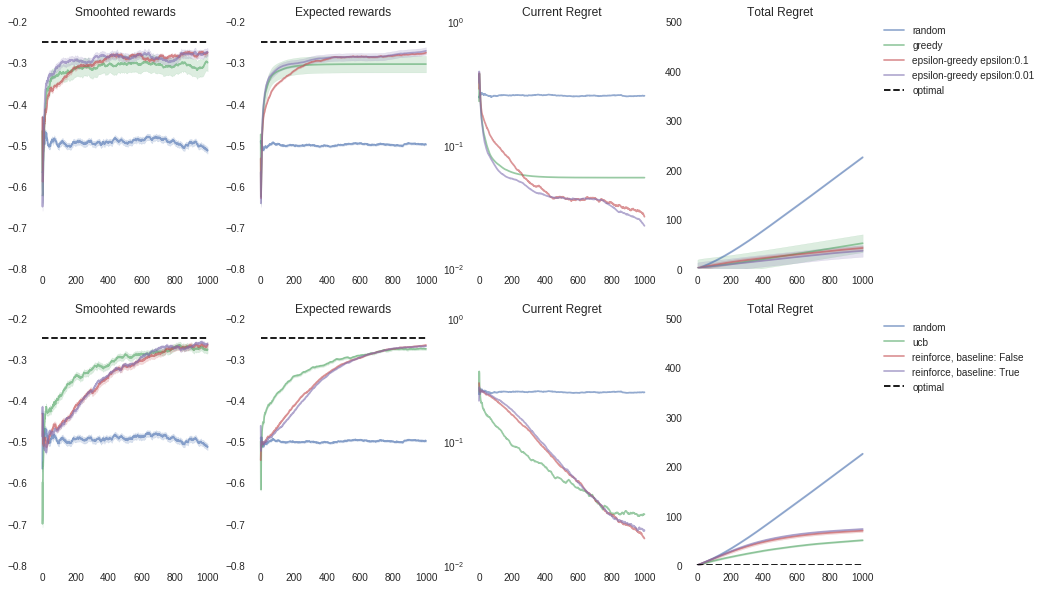

In [35]:
#@title Experiment 2: R = 0 on success, R = -1 on failure.
number_of_arms = 5
number_of_steps = 1000

train_agents(agents, number_of_arms, number_of_steps,
             success_reward=0., fail_reward=-1.)

## Assignment 5 b.
(Answer inline in the markdown.)

**[10pts]** Explain which algorithms improved from the changed rewards, and why.

(Use at most two sentences per algorithm and feel free to combine explanations for different algorithms where possible).

*The greedy improved significantly. Since once a failure occurs, this reward becomes negative, the rest four actions still have zero cumulated rewards. Therefore, the greedy algorithm has more opportunity to explore and won't lock onto one specific action at the very beignnering. *

*$\epsilon = 0.01$ method improved more quickly than the $\epsilon = 0.1$, that has the same reason as above that this experiment 2 setting makes the algorithm explore more when rewards start to cumnlate negatively. *

*UCB didn't change much.*

*Both reinforce with or without baseline have similar performance. Moreover,the algorithm witout baseline performs a little bit better than the algorithm with baseline here. That's because when we set without baseline, we are setting baseline = 0. In the second experiment 2, the average reward is negavtive, and is much closer to 0(since our algorithm wants as much success as possible), therefore, reinforce algorithm with and without baseline are have a more similar performance. *